##I. Descrição do problema##

Dataset  composto por medidas de PA de pacientes , sendo divididas em SBP e DBP.

Medidas coletadas a cada 15´ em 3 turnos e 30´ em 1 turno = 82 medidas em 24h


Há 9 tipos de Doenças Padrão conhecidas: White-Coat, Dipping, Non-Dipping, Masked, Ambulatory Hypotension, Isolated Systolic, Isolated Diastolic, Reverse Dipping, Morning Surge. E um padrão, que não é considerado doença, mas deve compor a classificacção que é Normotenso.

**Objetivo:** clusterizar os padrões de doenças


**DEFINIÇÕES**

IDADE >=60 then é idoso, else é jovem

**PERÍODOS**

* Matutino: 6h-8h59
* Diurno: 9h-20h59
* Vespertino: 21h-22h59
* Noturno: 23h-05h59



**Para SBP:**

LINHA_MAX = 140			LINHA_MIN = 100		

**Para DBP:**

LINHA_MAX = 90			LINHA_MIN = 60

**PADRÕES de DOENÇAS**

* WHITE COAT: 1a. média SBP >= todas outras médias
* MASKED:   if NOTURNO and any SBP>=140,  informar qtde de janelas >=140
* AMBULATORY HIPOTENSION: if any SBP <90 or any DBP <60
* ISOLATED SYSTOLIC:  if any SBP >140 and 60< DBP <90 ?????? 
* ISOLATED DIASTOLIC:  100< SBP <140 and any DBP >90
* DIPPING:  calcular SPB diurna; calcular SBP noturna; 
   Calcular dif=% da SBP noturna comparado com a diurna
      if 10< dif < 20 then DIPPING
      if dif > 10 then NON DIPPING
      if dif > 20 then EXTREME DIPPING
* REVERSE DIPPING: if SBP Noturna >= SBP Diurna
* MORNING SURGE:  if DIPPING, calcular SBP matinal
      if SBP matinal > 10% da SBP Noturna
* NORMOTENSA



##Abordagem do problema##

Tipo de aprendizagem:  Aprendizagem não supervisionada (Clausterização)

Dados: Dataset com 7.915 pacientes e 603.576 medidas de Pressão Arterial (PA) considerando a Sistólica (SBP) e Diastólica (DSP) coletadas por 24 horas, sendo a cada 15 minutos nos períodos Diurno, Matutino, Vespertino e a cada 30 minutos no período Noturno. Dessa forma, totalizamos 82 medidas diárias por paciente. Essa base de dados contém pacientes do gênero masculino e feminino com idade mínima de 10 anos e máxima de 100 anos. O método de coleta das medidas foi realizado com metodologia padrão acreditada pela American College of Cardiology/American Heart Association Task Force.

Modelo:

Objetivo: Utilizar método de análise automatizada para identificar e classificar cada paciente nos nove padrões de doenças Hipertensiva e um padrão normal descrita pela sociedade médica e, identificar padrões não conhecidos, caso existam.

Críterio:

Técnica de otimização: K-means

Importa as bibliotecas necessárias

In [1]:
''' # Cria o arquivo de configuracao

# Esse arquivo fica fora do GIT e guarda as diferencas de diretorios
# entre diferentes computadores. Todos os notebooks do projeto
# vao ler as configurações desse arquivo

a = open('config_diretorios.py', 'wt')
a.write("""\
from pathlib import Path

DRIVE = Path("C:\\\\")
DIR_PREFIXO = "users/marta/Documents"
""")
a.close()
'''

' # Cria o arquivo de configuracao\n\n# Esse arquivo fica fora do GIT e guarda as diferencas de diretorios\n# entre diferentes computadores. Todos os notebooks do projeto\n# vao ler as configurações desse arquivo\n\na = open(\'config_diretorios.py\', \'wt\')\na.write("""from pathlib import Path\n\nDRIVE = Path("C:\\\\")\nDIR_PREFIXO = "users/marta/Documents"\n""")\na.close()\n'

In [2]:
%matplotlib inline

import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics

from pathlib import Path

In [3]:
# Configurações regionais para formatação de números, etc (ex. separador de milhar'.' e decimal ',')
import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.utf-8')

# Definição se disco C: (laptop) ou D: (desktop) 
config_dirs = open("prefixo_dados.txt").readlines() 
DIR_PREFIXO = Path(config_dirs[0].strip())


DIR_DATASET = DIR_PREFIXO / "PA_clean" / "dataset"
DIR_DESFECHO = DIR_PREFIXO / "PA_clean" / "desfecho"
DIR_IMPUTACAO = DIR_DESFECHO / "imputacao"
DIR_GRAFICOS_IMPUTACAO = DIR_IMPUTACAO / "graficos_imputacao"
DIR_QUANTITATIVOS = DIR_IMPUTACAO / "quantitativos_imputacao"

# define regra de descarte: pacientes com mais de 70% das medidas faltantes são descartados
LIMIAR_DE_DESCARTE = 0.3

Carrega a base de dados e exibe os 5 primeiros pacientes

In [4]:

filepath = DIR_DESFECHO / "dataset" / r'comdesfecho_Encontrados.csv'

dados_brutos = pd.read_csv(filepath ,encoding='cp860',sep=';', dtype={'idade':int})
                # index_col=0 # Descomentar se aparecer a coluna "Unnamed"

#if "Unnamed: 0" in dados_brutos:
#    dados_brutos.drop("Unnamed: 0", 1, inplace=True)
#dados_brutos.head()

In [5]:
dados_brutos

,numero_identificacao,nome,data_nascimento,genero,idade,peso,altura,data_exame,sist 9:00,sist 9:15,...,mech_complication_mi___4,outcome_thrombus,outcome_nosocom_infect_v,outcome_hyperglycemia_v,gastrointest_bleed_v,outcome_hb_drop_v,outcome_neutropenia_v,outcome_transaminase_v,comments_f16_v,desfechos_complete
0,3766,CLAUDIO SASAOKA,1968-03-12,M,51,95.0,"1,84",2019-03-27 14:41:24,119.0,119.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,9201,PEDRO AUGUSTO LEMOS DE CASTRO,1980-05-01,M,39,76.0,162,2019-08-06 09:08:09,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,12770,DANYELLE COELHO DE ARAUJO SOUSA,2000-05-01,F,19,85.0,158,2019-11-06 13:34:16,98.0,116.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2
3,6295,MARGARIDA MARIA DE BRITO RABELO,1954-03-01,F,65,63.0,163,2019-05-28 10:27:03,134.0,124.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,883,ANA ELIZABETH DA SILVEIRA C.SIQUEIRA,1958-09-24,F,60,68.0,"1,53",2019-01-28 11:04:12,129.0,127.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,19559,MARLENE DIAS FEIJ╙,1964-02-15,F,56,75.0,"1,58",2020-07-08 08:52:47,113.0,NaN,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2
1404,5623,SIDNEI CORREA MARQUES,1953-06-25,M,65,76.0,174,2019-05-14 08:29:00,NaN,113.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2
1405,16685,VANDI DA COSTA,1943-03-23,F,76,70.0,173,2020-02-28 08:06:00,NaN,126.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1406,11603,UBIRACY TEIXEIRA BRAZAO,1938-08-11,M,81,70.0,168,2019-10-07 14:25:14,169.0,164.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2


Seleciona somente as medidas de pressão sistólica e diastólica e ignora os outros campos para compor as entradas do algoritmo de aprendizagem

In [6]:
 for i in dados_brutos.columns:
        print(i)

numero_identificacao
nome
data_nascimento
genero
idade
peso
altura
data_exame
sist 9:00
sist 9:15
sist 9:30
sist 9:45
sist 10:00
sist 10:15
sist 10:30
sist 10:45
sist 11:00
sist 11:15
sist 11:30
sist 11:45
sist 12:00
sist 12:15
sist 12:30
sist 12:45
sist 13:00
sist 13:15
sist 13:30
sist 13:45
sist 14:00
sist 14:15
sist 14:30
sist 14:45
sist 15:00
sist 15:15
sist 15:30
sist 15:45
sist 16:00
sist 16:15
sist 16:30
sist 16:45
sist 17:00
sist 17:15
sist 17:30
sist 17:45
sist 18:00
sist 18:15
sist 18:30
sist 18:45
sist 19:00
sist 19:15
sist 19:30
sist 19:45
sist 20:00
sist 20:15
sist 20:30
sist 20:45
sist 21:00
sist 21:15
sist 21:30
sist 21:45
sist 22:00
sist 22:15
sist 22:30
sist 22:45
sist 23:00
sist 23:30
sist 0:00
sist 0:30
sist 1:00
sist 1:30
sist 2:00
sist 2:30
sist 3:00
sist 3:30
sist 4:00
sist 4:30
sist 5:00
sist 5:30
sist 6:00
sist 6:15
sist 6:30
sist 6:45
sist 7:00
sist 7:15
sist 7:30
sist 7:45
sist 8:00
sist 8:15
sist 8:30
sist 8:45
diast 9:00
diast 9:15
diast 9:30
diast 9:45
dias

In [7]:
# Identifica o tamanho do dataset input e os nomes das colunas
# print('Size of dataset: ' + str(dados_brutos.shape ))
# print(list(dados_brutos))  # print feature list
# apenas as medidas dos pacientes
data_input = dados_brutos.loc[:,'sist 9:00':'diast 8:45'].copy()

qtd_antes_descarte = len(dados_brutos)

# data_input.values
# print(data_input.shape)

# Total de 82 medidas para cada tipo de dado:
df_sist_bruto = data_input.loc[:, "sist 9:00": "sist 8:45"]
df_diast_bruto = data_input.loc[:, "diast 9:00": "diast 8:45"]

# Dataframe com TODOS os campos
# Metadados = campos de cadastro, peso, data do exame
df_metadados = dados_brutos.loc[:, "numero_identificacao": "data_exame"]
df_desfechos = dados_brutos.loc[:,'comments_f14_v':]

In [8]:
data_input

,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,sist 10:45,sist 11:00,sist 11:15,...,diast 6:30,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45
0,119.0,119.0,127.0,111.0,108.0,119.0,119.0,124.0,121.0,107.0,...,78.0,NaN,79.0,NaN,NaN,78.0,65.0,NaN,NaN,87.0
1,NaN,NaN,131.0,NaN,125.0,120.0,121.0,122.0,128.0,117.0,...,64.0,NaN,59.0,78.0,92.0,NaN,NaN,NaN,NaN,NaN
2,98.0,116.0,115.0,109.0,116.0,113.0,112.0,NaN,139.0,121.0,...,55.0,NaN,53.0,NaN,83.0,43.0,NaN,67.0,94.0,80.0
3,134.0,124.0,133.0,NaN,NaN,NaN,NaN,NaN,131.0,137.0,...,73.0,NaN,82.0,90.0,81.0,86.0,83.0,84.0,82.0,81.0
4,129.0,127.0,122.0,128.0,128.0,NaN,NaN,NaN,NaN,NaN,...,67.0,NaN,90.0,94.0,92.0,86.0,103.0,97.0,96.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,113.0,NaN,NaN,123.0,122.0,114.0,113.0,113.0,108.0,133.0,...,47.0,NaN,67.0,54.0,76.0,78.0,64.0,NaN,NaN,81.0
1404,NaN,113.0,111.0,126.0,120.0,NaN,93.0,106.0,153.0,NaN,...,84.0,NaN,75.0,68.0,64.0,70.0,69.0,75.0,81.0,88.0
1405,NaN,126.0,131.0,137.0,137.0,126.0,128.0,129.0,125.0,131.0,...,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1406,169.0,164.0,152.0,152.0,178.0,163.0,166.0,166.0,154.0,152.0,...,98.0,NaN,105.0,96.0,114.0,89.0,96.0,92.0,93.0,92.0


## Distribuição quanto a gênero dos pacientes ANTES da imputação e do descarte

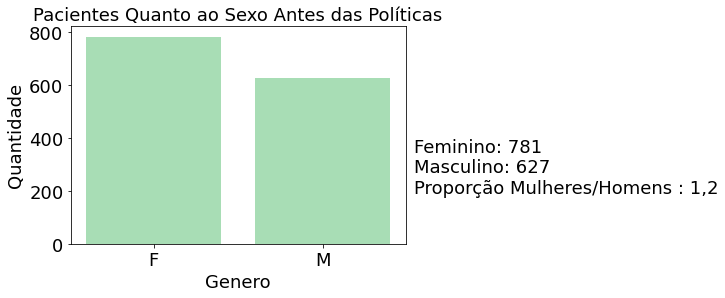

In [9]:
# parâmetros do gráfico
#
plt.rcParams.update({'font.size': 18})


def plota_histograma_genero(dados, extra="Antes das Políticas"):
    # conta quantos pacientes do sexo masculino e do feminino
    gender = dados['genero'].value_counts()
    gender = gender[["F", "M"]]
    plt.bar(gender.index,gender,color="#a8ddb5")
    #plt.gca().set(title=f'Pacientes Quanto ao Sexo {extra}', ylabel='Quantidade')
    plt.ylabel('Quantidade',fontsize=18)
    plt.xlabel('Genero',fontsize=18)
    plt.title(f'Pacientes Quanto ao Sexo {extra}',fontsize=18)
    
    legenda = f"Feminino: {gender['F']:n}\nMasculino: {gender['M']:n}"
    # Os operadores aumentados '+=', '-=', etc... fazem uma operação com, e guardam o resultado de volta, na variável da esquerda:
    # a = 10; a += 5 , resulta em a == 15
    legenda += "\n" + f"Proporção Mulheres/Homens : { gender['F'] / gender['M']:.02n}"
    plt.gcf().text(0.92, 0.3, legenda, fontsize=18)
    plt.savefig(DIR_GRAFICOS_IMPUTACAO / f"grafico_distribuicao_genero_{extra.replace(' ', '_')}.png", bbox_inches='tight')
          
plota_histograma_genero(dados_brutos)

## Distribuição quanto a idade dos pacientes ANTES da imputação e do descarte

In [10]:
dados_brutos

,numero_identificacao,nome,data_nascimento,genero,idade,peso,altura,data_exame,sist 9:00,sist 9:15,...,mech_complication_mi___4,outcome_thrombus,outcome_nosocom_infect_v,outcome_hyperglycemia_v,gastrointest_bleed_v,outcome_hb_drop_v,outcome_neutropenia_v,outcome_transaminase_v,comments_f16_v,desfechos_complete
0,3766,CLAUDIO SASAOKA,1968-03-12,M,51,95.0,"1,84",2019-03-27 14:41:24,119.0,119.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,9201,PEDRO AUGUSTO LEMOS DE CASTRO,1980-05-01,M,39,76.0,162,2019-08-06 09:08:09,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,12770,DANYELLE COELHO DE ARAUJO SOUSA,2000-05-01,F,19,85.0,158,2019-11-06 13:34:16,98.0,116.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2
3,6295,MARGARIDA MARIA DE BRITO RABELO,1954-03-01,F,65,63.0,163,2019-05-28 10:27:03,134.0,124.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,883,ANA ELIZABETH DA SILVEIRA C.SIQUEIRA,1958-09-24,F,60,68.0,"1,53",2019-01-28 11:04:12,129.0,127.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,19559,MARLENE DIAS FEIJ╙,1964-02-15,F,56,75.0,"1,58",2020-07-08 08:52:47,113.0,NaN,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2
1404,5623,SIDNEI CORREA MARQUES,1953-06-25,M,65,76.0,174,2019-05-14 08:29:00,NaN,113.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2
1405,16685,VANDI DA COSTA,1943-03-23,F,76,70.0,173,2020-02-28 08:06:00,NaN,126.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1406,11603,UBIRACY TEIXEIRA BRAZAO,1938-08-11,M,81,70.0,168,2019-10-07 14:25:14,169.0,164.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2


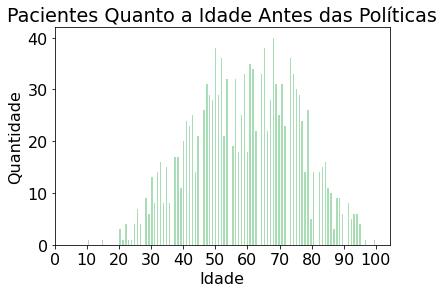

In [11]:
# Distribuição quanto à idade ANTES da imputação e do descarte
#
plt.rcParams.update({'font.size': 16})

def plota_histograma_idade(dados, extra='Antes das Políticas'):
    data_nascimento = pd.to_datetime(dados_brutos.iloc[dados_brutos.index]['data_nascimento']).dt.date
    data_atual = datetime.date.today()
    idade = (data_atual - data_nascimento).astype('<m8[Y]')
    #print(set(idade))
    #print(len(set(idade)))
    plt.hist(idade,bins=100,color="#a8ddb5", rwidth=0.5)
    plt.gca().set(title=f'Pacientes Quanto a Idade {extra}', 
                  ylabel='Quantidade', xlabel='Idade')
    plt.xticks(ticks=np.arange(0, 101, step=10))
    #plt.xlabel(xlabel, fontsize=14)
    #plt.ylabel(ylabel, fontsize=14)
    #plt.title(titulo, fontsize=16)
    plt.savefig(DIR_GRAFICOS_IMPUTACAO / f"grafico_distribuicao_idade_{extra.replace(' ', '_')}.png", bbox_inches='tight')
                
plota_histograma_idade(dados_brutos)


In [12]:

statistics.median([130, 130, 140, 140])

data_input.columns

Index(['sist 9:00', 'sist 9:15', 'sist 9:30', 'sist 9:45', 'sist 10:00',
       'sist 10:15', 'sist 10:30', 'sist 10:45', 'sist 11:00', 'sist 11:15',
       ...
       'diast 6:30', 'diast 6:45', 'diast 7:00', 'diast 7:15', 'diast 7:30',
       'diast 7:45', 'diast 8:00', 'diast 8:15', 'diast 8:30', 'diast 8:45'],
      dtype='object', length=164)

## Realiza o preenchimento dos dados faltantes utilizando a média dos valores imediatamente anterior e posterior

In [13]:
# 
#  IMPUTAÇÃO
#
# Encontra as posições de medidas nos quais há o valor faltante e imputa dados artificiais com o critério de 
# média entre a medida anterior e a medida posterior
#
# MELHORIA FUTURA: calcular também séries inputando qualquer número de medidas faltantes, preenchendo com uma "reta"
# entre as medidas existentes (necessário também para área sob a curva)

def preenche_dados(medidas_de_pressao):
    """
        Recebe todas as colunas referentes a um tipo de medida - ex. df_sist e df_diast
        
        devolve data_frame com dados faltantes preenchidos de acordo com a regra:
           - se houver só um NaN entre duas medias boas é usada a mediana (= média, p/ 2 valores)
           entre essas medidas
           - no caso de mais valores NaN consecutivos, eles não são tocados.
        
        A função é chamada com os dados de medidas sistolicas,  e depois, com as diastolicas
        
        No notebook de 'padroes_de_doenca' há uma versão extendida dessa
        funçao que faz a inputação em multiplas colunas faltantes, com interpolação linear.
    """

    novas_linhas = []
    for _, linha in medidas_de_pressao.iterrows():
        nans = list(linha.isna())
        linha = list(linha)
        for i, isnan in enumerate(nans):
            if i == 0 or i == len(linha) - 1:
                continue
            if isnan and not nans[i - 1] and not nans[i + 1]:
                linha[i] = round(statistics.median((linha[i - 1], linha[i + 1])))
        novas_linhas.append(linha)
    return pd.DataFrame(columns=medidas_de_pressao.columns, data=novas_linhas)
#
#print(df_sist_bruto.iloc[699:700, :].values)
#print(preenche_dados(df_sist_bruto.iloc[699:700, : ]).values)

df_sist_preenchido = preenche_dados(df_sist_bruto)
df_diast_preenchido = preenche_dados(df_diast_bruto)
#  concatena Sist e Diast já preenchidas 
todas_as_medidas_preenchidas = pd.concat([df_sist_preenchido, df_diast_preenchido], axis=1)


## Identifica as células onde os valores estão nulos (NaN), ou seja, tentativas de medições em que ocorreram erros - antes e depois de preencher NaNs isolados (imputação)

In [14]:
#  Verifica quais células apresentam NaN
#  1 para null e 0 para non null

valores_nulos_bruto = pd.concat([df_sist_bruto.isnull(), df_diast_bruto.isnull()], axis=1)
#print(valores_nulos_bruto.iloc[39, :].values)

valores_nulos = pd.concat([df_sist_preenchido.isnull(), df_diast_preenchido.isnull()], axis=1)
#print(valores_nulos.iloc[39, :].values)


faltantes_bruto = valores_nulos_bruto.sum(axis=1)
faltantes_preenchido = valores_nulos.sum(axis=1)
percentual_reducao = (100 * (1 - faltantes_preenchido / faltantes_bruto)).round(2)

qtd_sem_medidas=pd.concat([
        dados_brutos['numero_identificacao'],
        valores_nulos_bruto.sum(axis=1),
        valores_nulos.sum(axis=1),
        percentual_reducao
    ], 
    axis=1
)
qtd_sem_medidas.columns = ['Num ID', 'Qdt nulas', 'Qtd nulas pós-imputação', 'Eficácia imputação (%)']

# gera arquivo com quantidade de NaNs por paciente

qtd_sem_medidas.to_excel(DIR_QUANTITATIVOS / 'Quantidade_de_Medidas_Faltantes_por_Paciente.xlsx',
                        index=False)

qtd_sem_medidas.head()

,Num ID,Qdt nulas,Qtd nulas pós-imputação,Eficácia imputação (%)
0,3766,22,16,27.27
1,9201,22,14,36.36
2,12770,12,0,100.00
3,6295,14,10,28.57
4,883,16,12,25.00


In [15]:
def funcao(a, b):
    a[0] = 50
    print("dentro da funcao:", a, b)   
d = [20,]
e = [30, ]
print("antes:", d, e)
funcao(d, e)
print("depois da funcao:", d, e)

x = pd.DataFrame([[10, 20, 30], [40, 50, 60], [70, 80, 90]], columns=["primeira", "segunda", "terceira"])
# print(x)
y = x.iloc[0, 0] = 100
# print(x, y, sep="\n\n")

def f2():
    return 5, 6

g, h = f2()
print("g:", g, "h:", h)

antes: [20] [30]
dentro da funcao: [50] [30]
depois da funcao: [50] [30]
g: 5 h: 6


In [16]:
#
#  Calcula o percentual de medidas ausentes


def calcula_percentual(df_medidas, percentual):
    # Verifica quais células apresentam NaN
    # todas_as_medidas = dados_brutos.concat([df_sist, df_diast], axis=1)
    valores_invalidos = df_medidas.isnull()
    # calcula a quantidade de NaNs por paciente
    indices_a_descartar = valores_invalidos.sum(axis=1) > percentual * df_medidas.shape[1]
    indices_a_descartar.name = "Descartado"
    return indices_a_descartar

#
# Grava csv com pacientes imputados E ainda não descartados

def grava_csv_qtd_so_imputados(indices_a_descartar): 
    df_soma_nulos = todas_as_medidas_preenchidas.isnull().sum(axis=1)
    df_soma_nulos.name = "Qtd NaNs"
    df_com_informacoes_de_validade = pd.concat([df_metadados, todas_as_medidas_preenchidas, 
                                                df_soma_nulos, indices_a_descartar], axis=1) 
    df = df_com_informacoes_de_validade
    
    # df_com_informacoes_de_validade.columns = list(pacientes_apos_regras.columns[:-2]) + ["Qtd NaNs", "Descartado"]
    df.to_csv(DIR_DESFECHO / "dataset" / "desfecho_pacientes_imputados_e_nao_descartados.csv", 
                                          sep=";", encoding="cp860")
    
#
# o operador "~" é de complemento, e pode ser usado com a coluna de valores booleanos
# para selecionar só as linhas que estão marcadas como "False"
#
#  Roda função para Descartar pacientes e gerar 2 dataframes, sendo um completo e outro sem a coluna de Whitecoat

def realiza_descarte_com_Whitecoat(indices_a_descartar, df_metadados, df_sist_para_funcao, df_diast_para_funcao, df_whitecoat,df_desfechos):
    """Processa os dados e descarta os pacientes indicados - 
    retorna 6 dataframes em sequencia, com os pacientes respectivamente removidos
    """

    df_sist_descartado = df_sist_para_funcao[~indices_a_descartar]
    df_diast_descartado = df_diast_para_funcao [~indices_a_descartar]
    df_metadados = df_metadados.copy()[~indices_a_descartar]
    df_whitecoat = df_whitecoat.copy()[~indices_a_descartar]
    df_desfechos = df_desfechos.copy()[~indices_a_descartar]
    dados_apos_descarte = pd.concat([df_metadados, df_sist_descartado, df_diast_descartado,df_desfechos], axis=1)
    dados_apos_descarte_com_Whitecoat = pd.concat([df_metadados, df_sist_descartado, df_diast_descartado, df_whitecoat,df_desfechos], axis=1)
    
    return (
        dados_apos_descarte,
        dados_apos_descarte_com_Whitecoat,
        df_metadados,
        df_sist_descartado,
        df_diast_descartado,
        df_whitecoat,
        df_desfechos
    )

## Funcao anterior, que não levava em conta a coluna de whitecoat
#
#def realiza_descarte(indices_a_descartar, df_metadados, df_sist_para_funcao, df_diast_para_funcao):
#    df_sist_descartado = df_sist_para_funcao [~indices_a_descartar]
#    df_diast_descartado = df_diast_para_funcao [~indices_a_descartar]
#    df_metadados = df_metadados.copy()[~indices_a_descartar]
#    dados_apos_descarte = pd.concat([df_metadados, df_sist_descartado, df_diast_descartado], axis=1)
#    return dados_apos_descarte, df_metadados, df_sist_descartado, df_diast_descartado

In [17]:

def grava_arquivos_finais(limiar_de_descarte, sufixo=""):
    # Chama função CALCULA_PERCENTUAL aplicando a regra de descarte > 70% de medidas faltantes (variável LIMIAR_DE_DESCARTE)
    indices_a_descartar = calcula_percentual(todas_as_medidas_preenchidas, limiar_de_descarte)

    grava_csv_qtd_so_imputados (indices_a_descartar)

    total_descartados = indices_a_descartar.sum()

    print(f"Total de pacientes a descartar com limiar {limiar_de_descarte}: {total_descartados}. Total de aceitos: {len(indices_a_descartar) - total_descartados}")

    df_info = pd.DataFrame([[qtd_antes_descarte, qtd_antes_descarte -  total_descartados, total_descartados],  ],
                           columns=["Total de pacientes", "total após descarte", "Quantidade de descartes"])
    df_info.to_csv(DIR_QUANTITATIVOS / "desfecho_totais_bruto_e_descartados.csv", sep=";", encoding="cp860", index=False)

    ######################################################################################################
    # Gera Dataframe com os pacientes imputados E descartados com todos os campos de medidas e meta-dados
    ######################################################################################################
    pacientes_aceitos, pacientes_apos_regras, df_metadados_apos_regras, df_sist_apos_regras, df_diast_apos_regras, \
    df_whitecoat_apos_regras, df_desfechos_apos_regras = \
        realiza_descarte_com_Whitecoat(
            indices_a_descartar=indices_a_descartar, 
            df_metadados=df_metadados,
            df_sist_para_funcao=df_sist_preenchido,
            df_diast_para_funcao=df_diast_preenchido,
            df_whitecoat=dados_brutos[["whitecoat"]],
            df_desfechos=df_desfechos
    )

    # pacientes_aceitos <- dataframe completo sem o whitecoat
    # pacientes_apos_regras <- dataframe completo, com a coluna de dados brutos para calculo do whitecoat


    todas_as_medidas_apos_regras = pd.concat([df_sist_apos_regras, df_diast_apos_regras], axis=1)

    # Dataframe com todos os dados dos pacientes aceitos após imputação e regra de descarte E Whitecoat
    # pacientes_apos_regras

    # Dataframe SEM Whitecoat com todos os dados dos pacientes aceitos após imputação e regra de descarte
    # pacientes_aceitos

    # Grava CSV mantendo dataframe com todos os campos de medidas e meta-dados:
    #  COM Whitecoat
    pacientes_apos_regras.to_csv(DIR_DESFECHO / "dataset" / f"desfecho_pacientes_apos_regras_com_whitecoat{'_' + sufixo if sufixo else ''}.csv", sep=";", encoding="cp860")

    # Grava CSV final mantendo dataframe com os campos de medidas e meta-dados, SEM WHITECOAT:
    #  SEM Whitecoat
    pacientes_aceitos.to_csv(DIR_DESFECHO / "dataset" / f"desfecho_pacientes_aceitos_SEM_whitecoat{'_' + sufixo if sufixo else ''}.csv", sep=";", encoding="cp860")

    #print(indices_a_descartar, todas_as_medidas.loc[~ indices_a_descartar] ,sep="\n\n")

    # Grava arquivo com quantitativo de pacientes descartados
    #
    qtd_pacientes_a_descartar = indices_a_descartar.sum()
    total_pacientes = data_input.shape[0]

    sumario_de_descarte = pd.DataFrame([[
            qtd_pacientes_a_descartar, 
            total_pacientes, 
            f"{100 * qtd_pacientes_a_descartar / total_pacientes :.02f}%"]     
        ],
        columns=["Qdt Pacientes Descartados", "Qtd Pacientes Total", "Percentual de Descarte"]
    )

    sumario_de_descarte.to_csv(DIR_QUANTITATIVOS / f"desfecho_Sumario_descartados{'_' + sufixo if sufixo else ''}.csv",
                            sep=';', index=False ,encoding='cp860')   
    return pacientes_aceitos, pacientes_apos_regras

pacientes_aceitos, pacientes_apos_regras = grava_arquivos_finais(LIMIAR_DE_DESCARTE)
                             
grava_arquivos_finais(0, "com_todas_as_medidas")

                             

Total de pacientes a descartar com limiar 0.3: 35. Total de aceitos: 1373
Total de pacientes a descartar com limiar 0: 1317. Total de aceitos: 91


(      numero_identificacao                                 nome  \
 2                    12770      DANYELLE COELHO DE ARAUJO SOUSA   
 23                    4088               ANA MARIA SILVA DUARTE   
 28                   16331       PAULA FREITAS DA COSTA MAYRINK   
 32                    4047               VALDEIR NEVES DE BRITO   
 35                    8841            SELMA PEREIRA DE OLIVEIRA   
 ...                    ...                                  ...   
 1347                 11197       KATIA ANTUNES CORREIRA PENETRA   
 1363                 16608  ELIZABETH CHRISTINA DO REGO BARROS    
 1388                  7382                 CARLA MARIA LETTIERI   
 1392                  1887     DANIELLE MOREIRA DE SOUZA FALCAO   
 1399                  1663              ROBERTO OLIVEIRA GARCIA   
 
      data_nascimento genero  idade   peso altura           data_exame  \
 2         2000-05-01      F     19   85.0    158  2019-11-06 13:34:16   
 23        1944-06-09      F     7

## Distribuição quanto ao gênero dos pacientes DEPOIS da imputação e do descarte

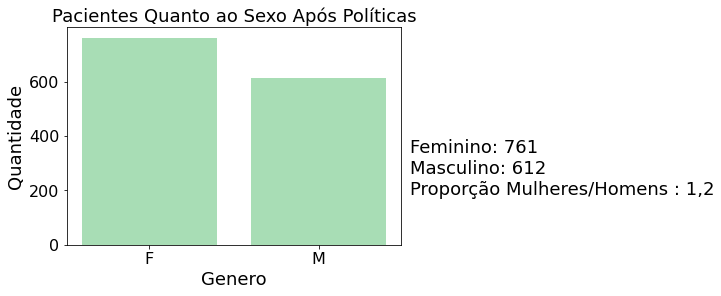

In [18]:
# Foram descartados 110 Mulheres e 84 Homens = 194   Faltam 3 ?????????????????????????????????????????????????

plota_histograma_genero(pacientes_apos_regras, extra='Após Políticas')



In [19]:
pacientes_aceitos.loc[1000]

numero_identificacao                           9269
nome                      RITA DE CASSIA DOS SANTOS
data_nascimento                          1971-08-23
genero                                            F
idade                                            47
                                    ...            
outcome_hb_drop_v                               0.0
outcome_neutropenia_v                           0.0
outcome_transaminase_v                          0.0
comments_f16_v                                  NaN
desfechos_complete                                2
Name: 1000, Length: 374, dtype: object

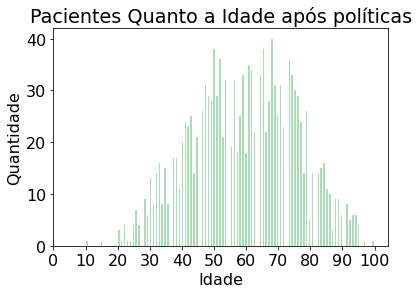

In [20]:
# Distribuição quanto à idade APÓS imputação e descarte


plota_histograma_idade(pacientes_apos_regras, extra='após políticas')


In [21]:
# Organizar 4 dataset com medidas de cada período 
# Matutino: 6h-8h59
# Diurno: 9h-20h59
# Vespertino: 21h-22h59
# Noturno: 23h-05h5


matutino=pd.concat((dados_brutos.loc[:,'numero_identificacao':'genero'],dados_brutos.loc[:,'sist 6:00':'sist 8:45'],dados_brutos.loc[:,'diast 6:00':'diast 8:45']),axis=1)
#matutino.head(10)
diurno=pd.concat((dados_brutos.loc[:,'numero_identificacao':'genero'],dados_brutos.loc[:,'sist 9:00':'sist 20:45'],dados_brutos.loc[:,'diast 9:00':'diast 20:45']),axis=1)
vespertino=pd.concat((dados_brutos.loc[:,'numero_identificacao':'genero'],dados_brutos.loc[:,'sist 21:00':'sist 22:45'],dados_brutos.loc[:,'diast 21:00':'diast 22:45']),axis=1)
noturno=pd.concat((dados_brutos.loc[:,'numero_identificacao':'genero'],dados_brutos.loc[:,'sist 23:00':'sist 5:30'],dados_brutos.loc[:,'diast 23:00':'diast 5:30']),axis=1)

In [22]:
# exemplo de uso e retorno da função "calcula_percentual"
indices_teste = calcula_percentual(noturno, .7)
sum(indices_teste)

# Exemplo de como funciona o dicionário retornado por "globals()"
# list(globals().keys())
# globals()["matutino"]

12

In [23]:
# Chama a função calcula_percentual para cada período. 
# Informar qual período se quer e, caso queira outro percentual diferente de 70

def gera_arquivos_de_invalidos_por_periodo(periodo, percentual):
    
    # Recupera o _valor_ da variável globa a partir do nome da variável como string:
    # (a chamada 'globals()' retorna todas as variáveis globais como um dicionário)
    dados_periodo = globals()[periodo]
    
    indices_a_descartar=calcula_percentual(dados_periodo, percentual)

    valido = dados_periodo[~indices_a_descartar]  # Pacientes válidos
    nao_valido = dados_periodo[indices_a_descartar] # Pacientes com mais de 70%  de dados faltantes no periodo noturno
    qtd_criterio = pd.Series(
        [sum(~indices_a_descartar), sum(indices_a_descartar), len(dados_periodo)],
        index = ["Atendido", "Não atendido", "Total"]
    )

    #periodo_matutino.head(10)
    valido.to_csv(path_or_buf= DIR_DESFECHO / "dataset" / f'desfecho_Pacientes_com_medidas_validas_periodo_{periodo}.csv',sep=';',index=False,encoding='cp860')
    nao_valido.to_csv(path_or_buf= DIR_DESFECHO / "dataset" / f'desfecho_Pacientes_nao_validos_periodo_{periodo}.csv',sep=';',index=False,encoding='cp860')
    # Usa 'index=True' pq nesse caso a série foi criada com os títulos de cada valor, que queremos ver no arquivo final:
    qtd_criterio.to_csv(path_or_buf= DIR_QUANTITATIVOS / f'desfecho_Qtd_Criterio_atendido_e_nao_atendido_{periodo}.csv',sep=';',index=True,header=False,encoding='cp860')

for periodo in ('noturno', 'matutino', 'diurno', 'vespertino'):
    gera_arquivos_de_invalidos_por_periodo(periodo, LIMIAR_DE_DESCARTE)
    